In [14]:
%matplotlib inline

import pandas as pd
import re
import codecs

from functools import reduce
from jupyterthemes import jtplot

# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='chesterish')

def neatify_headers(df):
    old_col_headers = list(df)
    new_col_headers = [och.replace(' ', '') for och in old_col_headers]
    rename_headers_map = {och: nch for och, nch in zip(old_col_headers, new_col_headers)}
    return df.rename(columns=rename_headers_map)

In [23]:
filenames = ('preschool_prek', 'k_2', '3_5', '6_8', '9_12')
dfs = []
for grade_category, filename in enumerate(filenames):
    df = pd.read_csv("{}.csv".format(filename))
    df = neatify_headers(df)
    df['GradeCategory'] = grade_category
    dfs.append(df)
df = reduce(lambda a, b: a.append(b), dfs)

In [25]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

standardize_text(df, "Annotation")

In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["Annotation"].apply(tokenizer.tokenize)
df.head()

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,Language,Genre,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory,tokens
0,41120,"1,2, Buckle My Shoe",striking quilt squares create a fabric frame f...,"Harcourt, Inc.",2008,NaN,NaN,Anna Grossnickle Hines,Anna Grossnickle Hines,"Preschool/Pre thru K, K thru 2",English,Poetry,"Counting Book, Picture Book, Read Aloud",NaN,"English-Language Arts/General, Mathematics","English-Language Arts/General , Mathematics",NaN,NaN,0,"[striking, quilt, squares, create, a, fabric, ..."
1,41223,1-2-3 Peas,a cast of energetic peas count by ones and ten...,Beach Lane Books,2012,NaN,NaN,Keith Baker,Keith Baker,"Preschool/Pre thru K, K thru 2",English,Fiction,"Concept Book, Counting Book, Picture Book",NaN,Number Sense,"English-Language Arts/General , Mathematics","Math K.CC.1-7, Math 1.NBT.1-6",NaN,0,"[a, cast, of, energetic, peas, count, by, ones..."
2,41021,10 Hungry Rabbits: Counting & Color Concepts,an early concept book that focuses on counting...,Alfred A. Knopf,2012,NaN,NaN,Anita Lobel,Anita Lobel,Preschool/Pre thru K,English,Fiction,"Concept Book, Counting Book, Picture Book",NaN,English-Language Arts/General,"English-Language Arts/General , Literacy/Motiv...",NaN,NaN,0,"[an, early, concept, book, that, focuses, on, ..."
3,40654,10 Turkeys in the Road,ten silly turkeys rehearsing for the turkey ci...,Marshall Cavendish Children,2011,NaN,NaN,Brenda Reeves Sturgis,David Slonim,"Preschool/Pre thru K, K thru 2",English,"Fiction, Humor","Counting Book, Picture Book",NaN,"English-Language Arts/General, Number Sense","English-Language Arts/General , Mathematics","Math K.CC.1-7, Math 1.OA.1-8",NaN,0,"[ten, silly, turkeys, rehearsing, for, the, tu..."
4,40159,999 Tadpoles,"it is springtime, and 999 tadpoles have hatche...","NorthSouth Books, Inc.",2011,2003.0,Ken Kimura,Ken Kimura,Yasunari Murakami,"Preschool/Pre thru K, K thru 2",English,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[it, is, springtime, and, 999, tadpoles, have,..."


In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

/anaconda3/envs/insight/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


607049 words total, with a vocabulary size of 23695
Max sentence length is 167


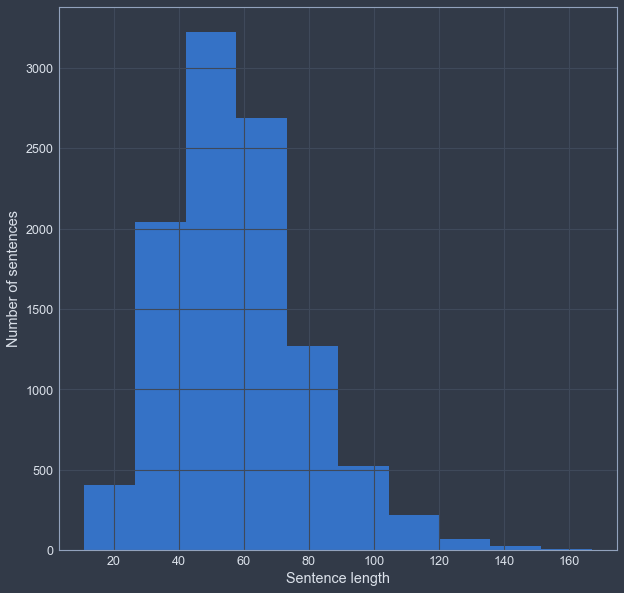

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### First, let's try a Bag of Words Counts approach

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df["Annotation"].tolist()
list_labels = df["GradeCategory"].tolist()

counts, count_vectorizer = cv(list_corpus)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(counts, list_labels, test_size=0.2, 
                                                                                random_state=40)

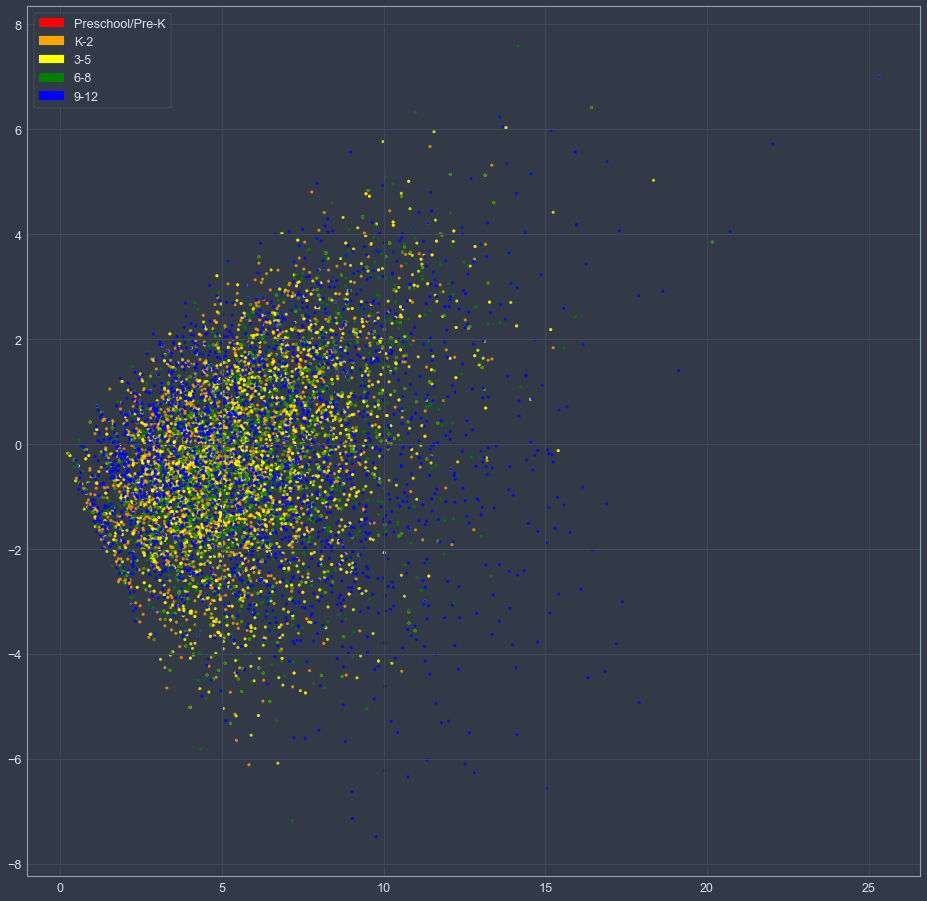

In [35]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red', 'orange', 'yellow', 'green', 'blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Preschool/Pre-K')
            orange_patch = mpatches.Patch(color='orange', label='K-2')
            yellow_patch = mpatches.Patch(color='yellow', label='3-5')
            green_patch = mpatches.Patch(color='green', label='6-8')
            blue_patch = mpatches.Patch(color='blue', label='9-12')
            plt.legend(handles=[red_patch, orange_patch, yellow_patch, green_patch, blue_patch])


fig = plt.figure(figsize=(16, 16))          
plot_LSA(counts, list_labels)
plt.show()

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train_counts)

y_predicted_counts = clf.predict(X_test_counts)

In [37]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test_counts, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.400, precision = 0.404, recall = 0.400, f1 = 0.402


In [38]:

import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

Normalized confusion matrix


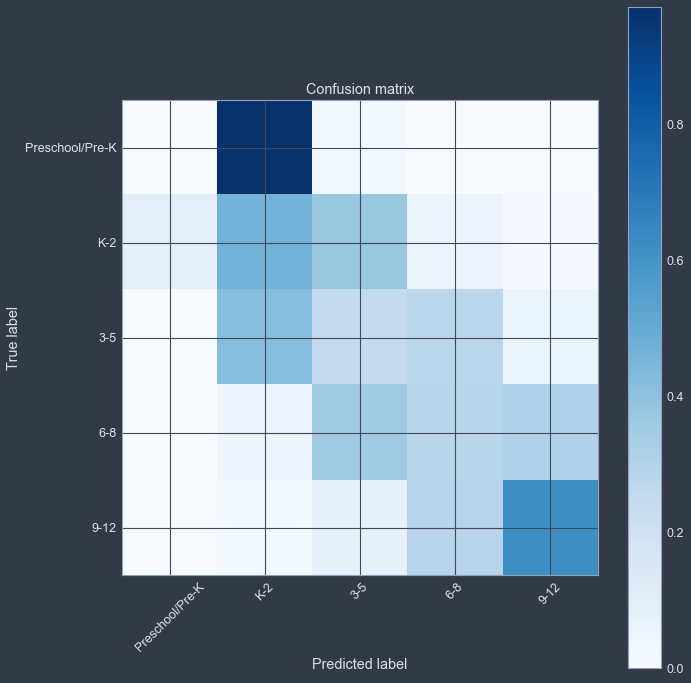

[[  0  36   1   0   0]
 [ 49 246 199  29   5]
 [  2 222 129 149  28]
 [  0  22 169 134 147]
 [  0  11  37 152 328]]


In [39]:
cm = confusion_matrix(y_test_counts, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Preschool/Pre-K','K-2','3-5', '6-8', '9-12'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [40]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

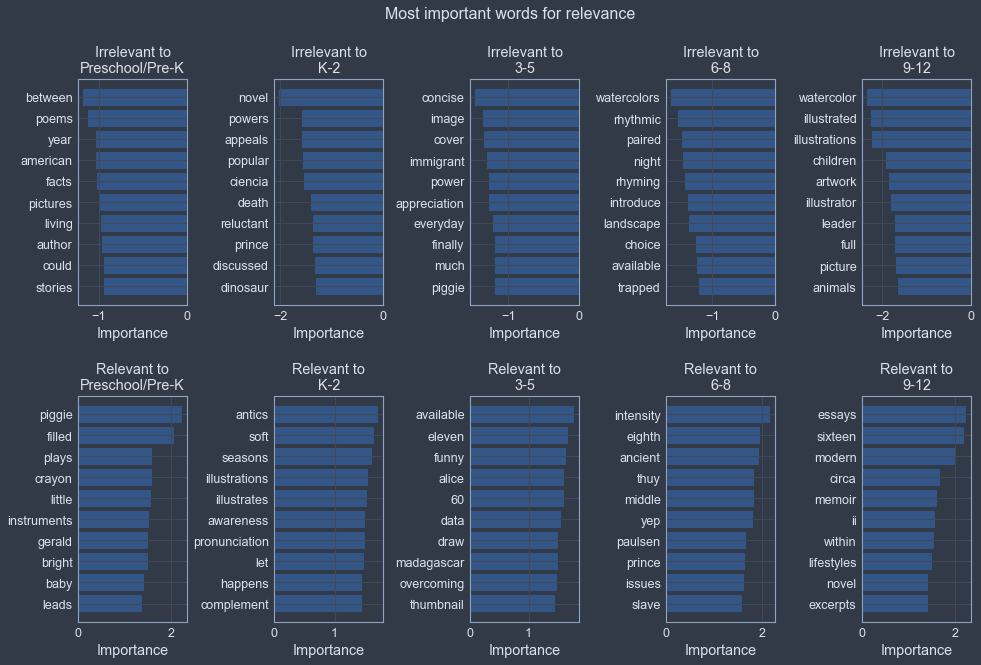

In [71]:
def plot_important_words(importance, name):
    fig = plt.figure(figsize=(16, 10))
    grade_categories = ('Preschool/Pre-K','K-2','3-5', '6-8', '9-12')
    for idx, grade_category in enumerate(grade_categories):
        
        top_scores = [a[0] for a in importance[idx]['tops']]
        top_words = [a[1] for a in importance[idx]['tops']]
        bottom_scores = [a[0] for a in importance[idx]['bottom']]
        bottom_words = [a[1] for a in importance[idx]['bottom']]
        
        y_pos = np.arange(len(top_words))
        
        plt.subplot(2, 5, 1 + idx)
        plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
        plt.title('Irrelevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, bottom_words)
        plt.suptitle('Key words', fontsize=16)
        plt.xlabel('Importance')

        plt.subplot(2, 5, 6 + idx)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title('Relevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, top_words)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8, hspace=0.4)
    plt.show()

plot_important_words(importance, "Most important words for relevance")

### TFIDF Bag of Words approach

In [72]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

tfidfs, tfidf_vectorizer = tfidf(list_corpus)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidfs, list_labels, test_size=0.2, 
                                                                            random_state=40)

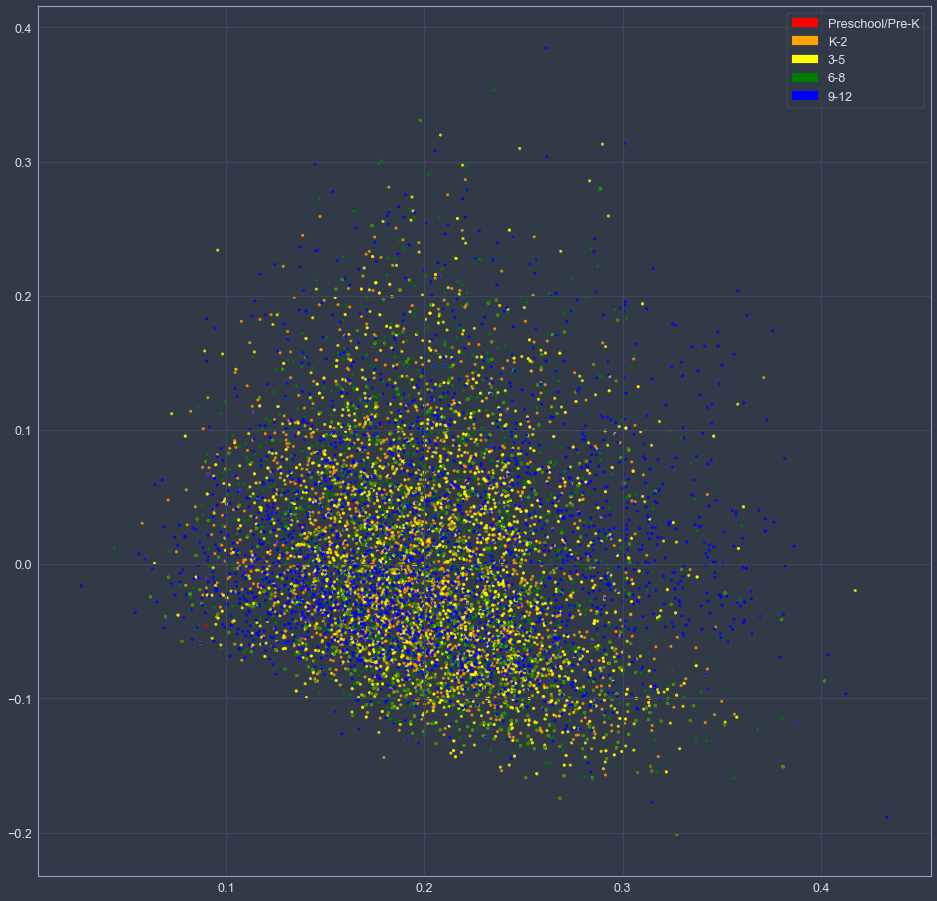

In [73]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidfs, list_labels)
plt.show()

In [74]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [75]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test_tfidf, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.418, precision = 0.423, recall = 0.418, f1 = 0.420


Normalized confusion matrix


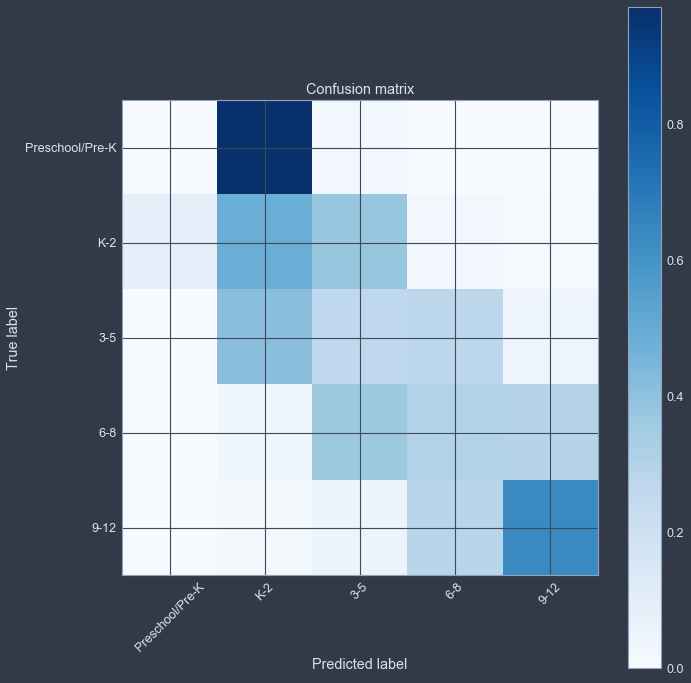

TFIDF confusion matrix
[[  0  36   1   0   0]
 [ 48 257 201  16   6]
 [  2 220 138 145  25]
 [  0  17 174 143 138]
 [  0  10  31 150 337]]
BoW confusion matrix
[[  0  36   1   0   0]
 [ 49 246 199  29   5]
 [  2 222 129 149  28]
 [  0  22 169 134 147]
 [  0  11  37 152 328]]


In [77]:
cm2 = confusion_matrix(y_test_tfidf, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
grade_categories = ('Preschool/Pre-K','K-2','3-5', '6-8', '9-12')
plot = plot_confusion_matrix(cm2, classes=grade_categories, normalize=True, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [78]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

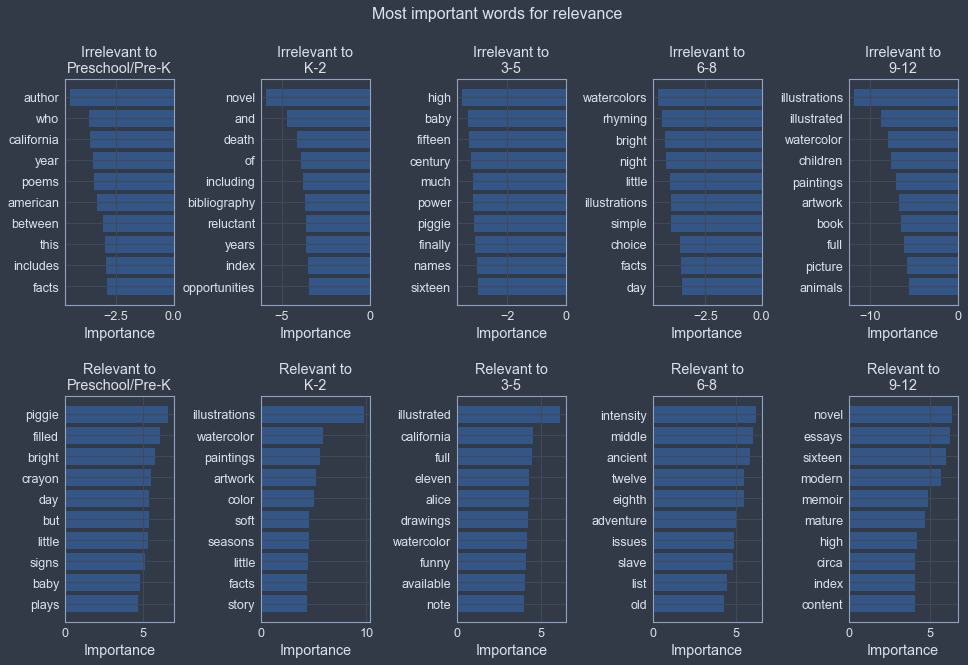

In [79]:
plot_important_words(importance_tfidf, "Most important words for relevance")

### Let's try word2vec

In [83]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'